# Examiniation of the relationsghip between NIHSS and thrombolysis in patients arriving within 6 hours of known stroke onset

Clinical assessment of stroke has been proposed as a method of selecting patients for transfer directly to comprehensive stroke centres which provide both thrombectomy and thrombolysis. USe of NIHSS has been shown to have the best performance of all clinical tests for prediction of large arety occlusion [1], though NIHSS is not easily or quickly performed pre-hospital, so simpler tests have been proposed, with RACE having the best performance [1], and having been shown to be well correlated with NIHSS [2].

In this experiement we look at how NIHSS predicts use of of thrombolysis, alongside publsihed results for NIHSS predicting the presence of large artery occlusion [2].


[1] Duvekot MHC, Venema E, Rozeman AD, et al. Comparison of eight prehospital stroke scales to detect intracranial large-vessel occlusion in suspected stroke (PRESTO): a prospective observational study. The Lancet Neurology 2021;20:213–21. doi:10.1016/S1474-4422(20)30439-7

[2] Turc G, Maïer B, Naggara O, et al. Clinical Scales Do Not Reliably Identify Acute Ischemic Stroke Patients With Large-Artery Occlusion. Stroke 2016;47:1466–72. doi:10.1161/STROKEAHA.116.013144


In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# import data
raw_data = pd.read_csv(
    './../data/2019-11-04-HQIP303-Exeter_MA.csv', low_memory=False)

## Restrict original data to hospitals with at least 300 admissions + 10 thrombolysis patients

In [2]:
keep = []

groups = raw_data.groupby('StrokeTeam') # creates a new object of groups of data

for index, group_df in groups: # each group has an index and a dataframe of data
    
    # Skip if total admissions less than 300 or total thrombolysis < 10
    admissions = group_df.shape[0]
    thrombolysis_received = group_df['S2Thrombolysis'] == 'Yes' 
    if (admissions < 300) or (thrombolysis_received.sum() < 10):
        continue
    
    else: 
        keep.append(group_df)

# Concatenate output
data = pd.DataFrame()
data = pd.concat(keep)

print (data.shape)

(239505, 62)


## Restrict to known NIHSS

In [3]:
# Restrict data to determined NIHSS
mask = data['S2NihssArrival'] >= 0
data = data[mask]

## Restrict to known onset within 6 hours

In [4]:
mask = (data['S1OnsetToArrival_min'] <= 360) & (data['S1OnsetToArrival_min'] >= 0)
print (f'Proportion with known onset of up to 6 hours: {mask.mean():0.3f}')
data = data[mask]

Proportion with known onset of up to 6 hours: 0.434


## Iterate through NIHSS cutoff

In [5]:
results = []
for nihss in range(0, 16):
    mask = data['S2NihssArrival'] >= nihss
    selected_data = data[mask]
    row_results = dict()
    row_results['Min NIHSS'] = nihss
    row_results['Proportion'] = selected_data.shape[0] / data.shape[0]
    row_results['Arrive in 4 hours'] = np.mean(selected_data['S1OnsetToArrival_min'] <= 240)
    row_results['Infarction'] = np.mean(selected_data['S2StrokeType'] == 'Infarction')
    row_results['Haemorrhage'] = np.mean(selected_data['S2StrokeType'] == 'Primary Intracerebral Haemorrhage')
    row_results['Thrombolysis'] = np.mean(selected_data['S2Thrombolysis'] == 'Yes')
    row_results['Prop of all thrombolysis'] = (
        np.sum(selected_data['S2Thrombolysis'] == 'Yes') / np.sum(data['S2Thrombolysis'] == 'Yes'))
        
    results.append(row_results)
    
results = pd.DataFrame(results)
results

,Min NIHSS,Proportion,Arrive in 4 hours,Infarction,Haemorrhage,Thrombolysis,Prop of all thrombolysis
0,0,1.000000,0.865353,0.863379,0.135339,0.263754,1.000000
1,1,0.949110,0.867161,0.861880,0.136977,0.276948,0.996591
2,2,0.873663,0.871033,0.856163,0.142784,0.298120,0.987500
3,3,0.772523,0.877520,0.846576,0.152381,0.328134,0.961089
4,4,0.681749,0.884194,0.836926,0.162104,0.355088,0.917829
5,5,0.603316,0.890638,0.827512,0.171495,0.370004,0.846356
6,6,0.536375,0.896123,0.817681,0.181298,0.376989,0.766654
7,7,0.479221,0.901052,0.808963,0.189980,0.380866,0.692006
8,8,0.431297,0.904100,0.800268,0.198629,0.381683,0.624138
9,9,0.390545,0.906716,0.792871,0.205938,0.380174,0.562931


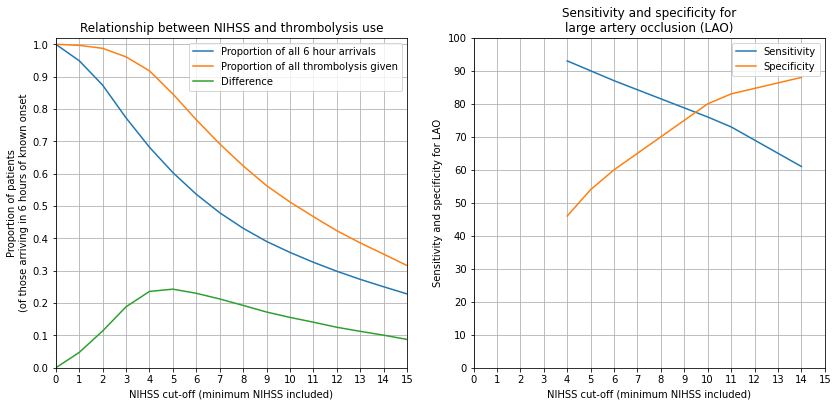

In [6]:
# Set up figure
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
x = results['Min NIHSS']
y1 = results['Proportion']
y2 = results['Prop of all thrombolysis']
y3 = y2 - y1

ax1.plot(x, y1, label = 'Proportion of all 6 hour arrivals')
ax1.plot(x, y2, label = 'Proportion of all thrombolysis given')
ax1.plot(x, y3, label = 'Difference')

ax1.set_xlabel('NIHSS cut-off (minimum NIHSS included)')
ax1.set_ylabel('Proportion of patients\n(of those arriving in 6 hours of known onset')

ax1.set_ylim(0, 1.02)
ax1.set_xlim(0, 15)
ax1.set_xticks(np.arange(0, 16))
ax1.set_yticks(np.arange(0, 1.01, 0.1))
ax1.legend()
ax1.grid()
ax1.set_title('Relationship between NIHSS and thrombolysis use')

# LAO performance
ax2 = fig.add_subplot(122)
x = [4,5,6,10,11,14]
sensitivity = [93, 90, 87, 76, 73, 61]
specificity = [46, 54, 60, 80, 83, 88]
ax2.plot(x, sensitivity, label = 'Sensitivity')
ax2.plot(x, specificity, label = 'Specificity')

ax2.set_xlabel('NIHSS cut-off (minimum NIHSS included)')
ax2.set_ylabel('Sensitivity and specificity for LAO')
ax2.set_xticks(np.arange(0, 16))
ax2.set_yticks(np.arange(0, 101, 10))
ax2.legend()
ax2.grid()
ax2.set_title('Sensitivity and specificity for\nlarge artery occlusion (LAO)')

plt.tight_layout(pad=2)

plt.savefig('output/nihss_cutoff.jpg', dpi=300)

plt.show()